In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, Binarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
train_labels_path = 'data/train_labels.csv'
train_values_path = 'data/train_values.csv'

train_labels = pd.read_csv(train_labels_path)
train_values = pd.read_csv(train_values_path)
data = train_values.merge(train_labels, on='building_id')

categorical_cols = [
    'land_surface_condition', 'foundation_type', 'roof_type',
    'ground_floor_type', 'other_floor_type', 'position',
    'plan_configuration', 'legal_ownership_status'
]

integer_cols = [
    'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
    'count_floors_pre_eq', 'age', 'area_percentage',
    'height_percentage', 'count_families'
]

binary_cols = [
    'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
    'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone',
    'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick',
    'has_superstructure_timber', 'has_superstructure_bamboo',
    'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered'
]

data.drop(columns=['count_families', 'legal_ownership_status'])


X = data.set_index('building_id').drop(['damage_grade'], axis=1)
y = data.set_index('building_id')['damage_grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('int', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), integer_cols),
        ('cat', OrdinalEncoder(handle_unknown='error'), categorical_cols),
        ('bin', Binarizer(), binary_cols)
    ],
    remainder='passthrough', verbose_feature_names_out=False
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

class FuzzyRandomForest(RandomForestClassifier):
    def __init__(self, n_estimators=400, fuzzy_param=1, random_state=None, min_samples_split=2, verbose=2,
                 max_features=None, max_depth=None, min_samples_leaf=1, max_leaf_nodes=None, class_weight=None, n_jobs=None):
        super().__init__(
            n_estimators=n_estimators,
            random_state=random_state,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            min_samples_split=min_samples_split,
            max_features=max_features,
            max_leaf_nodes=max_leaf_nodes,
            verbose=verbose,
            class_weight=class_weight,
            n_jobs=n_jobs
        )
        self.fuzzy_param = fuzzy_param

    def predict_proba_fuzzy(self, X):
        proba = super().predict_proba(X)
        fuzzy_proba = proba ** self.fuzzy_param
        fuzzy_proba /= fuzzy_proba.sum(axis=1, keepdims=True)
        return fuzzy_proba

    def predict_fuzzy(self, X):
        fuzzy_proba = self.predict_proba_fuzzy(X)
        return np.argmax(fuzzy_proba, axis=1) + 1

# Micro-F1を評価指標として設定
micro_f1_scorer = make_scorer(f1_score, average='micro')

# Skip gridSearchCV because of exhaustive search (longer runtime)
#param_grid = {
#    'max_depth': [None, 10, 15],
#    'min_samples_leaf': [1, 3, 5],
#    'fuzzy_param': [1, 1.2, 1.5],
#    'class_weight': [None, 'balanced_subsample']
#}

#grid_search = GridSearchCV(
#    estimator=frf,
#    param_grid=param_grid,
#    scoring=micro_f1_scorer,
#    cv=3,
#    n_jobs=-1
#)
#best_model = grid_search.best_estimator_
#print("Best Params:", grid_search.best_params_)
#print("Best Micro-F1 (CV):", grid_search.best_score_)

frf = FuzzyRandomForest(
    n_estimators = 650,
    max_features = 25,
    min_samples_split = 17,
    random_state=42,
    n_jobs=-1,
    )

frf.fit(X_train_processed, y_train)

y_pred_fuzzy = frf.predict_fuzzy(X_test_processed)
micro_f1_score_val = f1_score(y_test, y_pred_fuzzy, average='micro')

print("Test Micro-F1:", micro_f1_score_val)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 650
building tree 2 of 650
building tree 3 of 650
building tree 4 of 650
building tree 5 of 650
building tree 6 of 650
building tree 7 of 650
building tree 8 of 650
building tree 9 of 650
building tree 10 of 650
building tree 11 of 650
building tree 12 of 650
building tree 13 of 650
building tree 14 of 650
building tree 15 of 650
building tree 16 of 650
building tree 17 of 650
building tree 18 of 650
building tree 19 of 650
building tree 20 of 650
building tree 21 of 650
building tree 22 of 650
building tree 23 of 650
building tree 24 of 650
building tree 25 of 650
building tree 26 of 650
building tree 27 of 650
building tree 28 of 650
building tree 29 of 650
building tree 30 of 650
building tree 31 of 650
building tree 32 of 650
building tree 33 of 650
building tree 34 of 650
building tree 35 of 650
building tree 36 of 650
building tree 37 of 650


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.8s


building tree 38 of 650
building tree 39 of 650
building tree 40 of 650
building tree 41 of 650building tree 42 of 650
building tree 43 of 650
building tree 44 of 650
building tree 45 of 650

building tree 46 of 650
building tree 47 of 650
building tree 48 of 650
building tree 49 of 650
building tree 50 of 650
building tree 51 of 650
building tree 52 of 650
building tree 53 of 650
building tree 54 of 650
building tree 55 of 650
building tree 56 of 650
building tree 57 of 650
building tree 58 of 650
building tree 59 of 650
building tree 60 of 650
building tree 61 of 650
building tree 62 of 650
building tree 63 of 650
building tree 64 of 650
building tree 65 of 650
building tree 66 of 650
building tree 67 of 650
building tree 68 of 650
building tree 69 of 650
building tree 70 of 650
building tree 71 of 650
building tree 72 of 650
building tree 73 of 650
building tree 74 of 650
building tree 75 of 650
building tree 76 of 650
building tree 77 of 650
building tree 78 of 650
building tree 79

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   29.6s


building tree 156 of 650
building tree 157 of 650
building tree 158 of 650
building tree 159 of 650
building tree 160 of 650
building tree 161 of 650
building tree 162 of 650
building tree 163 of 650
building tree 164 of 650
building tree 165 of 650
building tree 166 of 650
building tree 167 of 650
building tree 168 of 650
building tree 169 of 650
building tree 170 of 650
building tree 171 of 650
building tree 172 of 650
building tree 173 of 650
building tree 174 of 650
building tree 175 of 650
building tree 176 of 650
building tree 177 of 650
building tree 178 of 650
building tree 179 of 650
building tree 180 of 650building tree 181 of 650

building tree 182 of 650
building tree 183 of 650
building tree 184 of 650
building tree 185 of 650
building tree 186 of 650
building tree 187 of 650
building tree 188 of 650
building tree 189 of 650
building tree 190 of 650
building tree 191 of 650
building tree 192 of 650
building tree 193 of 650
building tree 194 of 650
building tree 195 of 650


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min


building tree 359 of 650
building tree 360 of 650
building tree 361 of 650
building tree 362 of 650
building tree 363 of 650
building tree 364 of 650
building tree 365 of 650
building tree 366 of 650
building tree 367 of 650
building tree 368 of 650
building tree 369 of 650
building tree 370 of 650
building tree 371 of 650
building tree 372 of 650
building tree 373 of 650
building tree 374 of 650
building tree 375 of 650
building tree 376 of 650
building tree 377 of 650
building tree 378 of 650
building tree 379 of 650
building tree 380 of 650
building tree 381 of 650
building tree 382 of 650
building tree 383 of 650
building tree 384 of 650
building tree 385 of 650
building tree 386 of 650
building tree 387 of 650
building tree 388 of 650
building tree 389 of 650
building tree 390 of 650
building tree 391 of 650
building tree 392 of 650
building tree 393 of 650
building tree 394 of 650
building tree 395 of 650
building tree 396 of 650
building tree 397 of 650
building tree 398 of 650


[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.3min


building tree 642 of 650
building tree 643 of 650
building tree 644 of 650
building tree 645 of 650
building tree 646 of 650
building tree 647 of 650
building tree 648 of 650
building tree 649 of 650
building tree 650 of 650


[Parallel(n_jobs=-1)]: Done 650 out of 650 | elapsed:  2.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    1.3s


Test Micro-F1: 0.7416396462078625


[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 650 out of 650 | elapsed:    2.3s finished


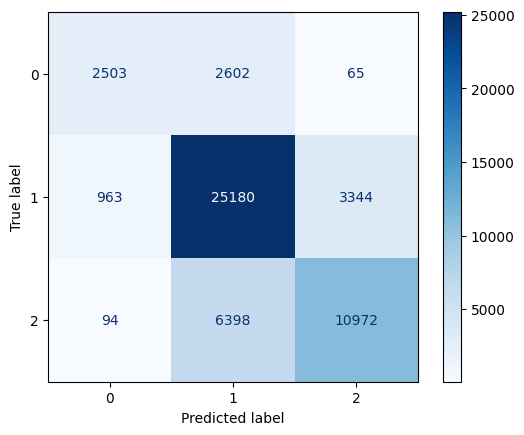

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_fuzzy)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()